<a href="https://colab.research.google.com/github/326-YL/403-Fall-2022/blob/main/hws/hw8/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW 8. Three DoF Planar Arm**

The goal of HW 8 is to create a dynamics simulation of a 3 DoF openchain system described in the figures below. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm_Kinematics.png?raw=true" height="400">
<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm_Dynamics.png?raw=true" height="400">

In [1]:
!pip3 install sympy matplotlib seaborn ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sympy as sym
from sympy import Symbol, simplify, lambdify
from sympy.matrices.expressions import transpose
from sympy import sin, cos, Matrix
import numpy as np
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
%matplotlib inline


# Declare Symbolic Variables

In [11]:
# Write your code: Symbolic variable definition. Complete the following variable list
[m1, m2, m3,c1,c2,c3,l1,l2,l3,I1,I2,I3,g] = sym.symbols('m1 m2 m3 c1 c2 c3 l1 l2 l3 I1 I2 I3 g')
[th1,th2,th3,dth1,dth2,dth3,ddth1,ddth2,ddth3] = sym.symbols('th1 th2 th3 dth1 dth2 dth3 ddth1 ddth2 ddth3')
[tau1, tau2, tau3] = sym.symbols('tau1 tau2 tau3')

# Symbolic variable groupings: No need to change
q  = Matrix([th1,  th2, th3])
dq = Matrix([dth1,  dth2, dth3])
ddq= Matrix([ddth1, ddth2, ddth3])
u  = Matrix([tau1, tau2, tau3]) # control input
z = Matrix([q.transpose(), dq.transpose()]) # state
p   = [l1, l2, l3, c1, c2, c3, m1, m2, m3, I1, I2, I3, g]  # parameters

zp_params = list(z)+list(p)
zup_params = list(z)+list(u)+list(p)

# Parameters: No need to change
m1_p = 1.5
m2_p = 1.
m3_p = 2.0
l1_p = .6
l2_p = .4
l3_p = .5
c1_p = .3
c2_p = .2
c3_p = .4
I1_p = 0.05
I2_p = 0.05
I3_p = 0.09

g_p  = 9.81    
params   = [l1_p, l2_p , l3_p, c1_p, c2_p, c3_p, m1_p, m2_p, m3_p, I1_p, I2_p, I3_p, g_p]

In [10]:
# Handy functions to be used to compute time derivative and generalized forces: No need to change
ddt = lambda x: x.jacobian(q)*dq + x.jacobian(dq)*ddq        # Time derivative
F2Q = lambda F, r : simplify(r.jacobian(q).transpose()*F)    # force contributions to generalized forces
M2Q = lambda M, w : simplify(w.jacobian(dq).transpose()*M)   # moment contributions to generalized forces

# **Q.1. [25 pts] Kinemeatics**

Complete the code to compute the positions and velocities of the points of interest. Here, all positions and velocities (angular and linear) should be defined to compute kinetic and potential energies.

In [5]:
# Kinemeatics
rO = Matrix([0, 0, 0])    # position of link 1
ehat1 =Matrix([sin(th1),cos(th1),0])          # Define unit vector along Leg 1
ehat2 =Matrix([sin(th1+th2),cos(th1+th2),0])  # Define unit vector along Leg 2
ehat3 =Matrix([sin(th1+th2+th3),cos(th1+th2+th3),0])  # Define unit vector along Leg 2

ghat  = Matrix([0, -1 , 0])                      

# Write your code: Define CoM position and link position
rB  =rO+Matrix([l1*sin(th1),l1*cos(th1),0]) # Position of base of link 2
print(f'rB:{rB}')
rC  =rB+Matrix([l2*sin(th1+th2),l2*cos(th1+th2),0])   # Position of end of link 3
print(rC)
rD  =rC+Matrix([l3*sin(th1+th2+th3),l3*cos(th1+th2+th3),0])   # Position of end of link 3

rc1 =c1*ehat1         # Position of link 1 CoM
rc2 =rB+c2*ehat2     # Position of CoM of link 2
rc3 =rC+c3*ehat3    # Position of CoM of link 3


# Write your code: Define linear and angular velocity of each link
# Hint: Utilize 'ddt' function

vc1 =ddt(rc1)         # Velocity of link 1 CoM
vc2 =ddt(rc2)         # Velocity of link 2 CoM
vc3 =ddt(rc3)         # Velocity of link 3 CoM

ac1=ddt(vc1)
ac2=ddt(vc2)
ac3=ddt(vc3)

keypoints = Matrix([[rO], [rB], [rC], [rD]]).reshape(4, 3)
keypoints_func = sym.lambdify(zp_params, keypoints)

rB:Matrix([[l1*sin(th1)], [l1*cos(th1)], [0]])
Matrix([[l1*sin(th1) + l2*sin(th1 + th2)], [l1*cos(th1) + l2*cos(th1 + th2)], [0]])


In [6]:
# Test Forward Kinematics implementation: No need to change
def test_forward_kinematics(params):

  test_config = [[0, 0, 0, 0, 0, 0],
                 [0, np.pi/4, np.pi/6, 0, 0, 0],
                 [np.pi/8, -0.6, 0, 0, 0, 0]]
  res = []
  soln = np.array([[[ 0., 0., 0.],
           [ 0., 0.6, 0.],
           [ 0., 1., 0.],
           [ 0., 1.5, 0.]],
        [[ 0.,          0.,          0.],
          [ 0.,         0.6,         0.],
          [ 0.28284271, 0.88284271,  0.],
          [ 0.76580563, 1.01225224,  0.]],
        [[0.,          0.,          0.],
          [ 0.22961006, 0.55432772,  0.],
          [ 0.14728232, 0.94576372,  0. ],
          [ 0.04437264, 1.43505872,  0. ]]])
  
  for i, q in enumerate(test_config): 
    xp_params = q + list(params)
    res.append(keypoints_func(*xp_params))
  res_np = np.array(res)
  
  assert np.allclose(soln, res_np), f'Your Forward kinematics implementation is wrong soln: {soln} != res: {res_np}'

  print('Your Forward Kinematics implementation is correct!')

In [7]:
test_forward_kinematics(params)

Your Forward Kinematics implementation is correct!


# **Q.2. [20 pts] Kinetic and Potential Energy of Links**

Define the kinetic and potential energy of each link

In [8]:
# Write your code: Kinetic and Potential Energy of link 1
T1 =simplify(1/2*m1*vc1.dot(vc1)+1/2*I1*dth1*dth1)
V1=m1*g*rc1.dot(-ghat)

# Write your code: Kinetic and Potential Energy of link 2
T2 =simplify(1/2*m2*vc2.dot(vc2)+1/2*I2*(dth1+dth2)*(dth1+dth2))
V2 =m2*g*rc2.dot(-ghat)

# Write your code: Kinetic and Potential Energy of link 3
T3 =simplify(1/2*m3*vc3.dot(vc3)+1/2*I3*(dth1+dth2+dth3)*(dth1+dth2+dth3))
V3 =m3*g*rc3.dot(-ghat)

# **Q.3. [15 pts] Lagrangian and Total Energy (Hamiltonian)**

In [9]:
# Write your code: Kinetic, Potential, and total energy of the entire system
KE =T1+T2+T3
PE =V1+V2+V3
E =KE+PE

# Write your code: Lagrangian
L =Matrix([simplify(KE-PE)])

# **Q.3. [20 pts] Generalized Forces**

Define generalized force vectors using a M2Q function. 

Hint: The result should be $Q = \begin{pmatrix}\tau_1 \\ \tau_2 \\ \tau_3\end{pmatrix}$. 

In [12]:
# Write your code: 
Q_tau1 =M2Q(tau1,Matrix([dth1]))
Q_tau2 =M2Q(tau2,Matrix([dth1+dth2]))+M2Q(-tau2,Matrix([dth1]))
Q_tau3 =M2Q(tau3,Matrix([dth1+dth2+dth3]))+M2Q(-tau3,Matrix([dth1+dth2]))

Q =Q_tau1+Q_tau2+Q_tau3

print(Q_tau1)
print(Q_tau2)
print(Q_tau3)

print(Q)

Matrix([[tau1], [0], [0]])
Matrix([[0], [tau2], [0]])
Matrix([[0], [0], [tau3]])
Matrix([[tau1], [tau2], [tau3]])


# **Q.4. [10 pts] Equations of Motion**

Complete the equations of motion by applying Lagrange formula. Find A (Mass matrix) and b vector explained in the lecture.

In [13]:
dL_dq=L.jacobian(q).transpose()
dL_dqd=L.jacobian(dq).transpose()
g=ddt(dL_dqd)-dL_dq-Q

A =g.jacobian(ddq)

b =simplify(A*ddq-g)

In [ ]:
A

Matrix([
[1.0*I1 + 1.0*I2 + 1.0*I3 + 1.0*c1**2*m1 + 0.5*m2*(2*c2**2 + 4*c2*l1*cos(th2) + 2*l1**2) + 0.5*m3*(2*c3**2 + 4*c3*l1*cos(th2 + th3) + 4*c3*l2*cos(th3) + 2*l1**2 + 4*l1*l2*cos(th2) + 2*l2**2), 1.0*I2 + 1.0*I3 + 0.5*m2*(2*c2**2 + 2*c2*l1*cos(th2)) + 0.5*m3*(2*c3**2 + 2*c3*l1*cos(th2 + th3) + 4*c3*l2*cos(th3) + 2*l1*l2*cos(th2) + 2*l2**2), 1.0*I3 + 0.5*m3*(2*c3**2 + 2*c3*l1*cos(th2 + th3) + 2*c3*l2*cos(th3))],
[                                            1.0*I2 + 1.0*I3 + 0.5*m2*(2*c2**2 + 2*c2*l1*cos(th2)) + 0.5*m3*(2*c3**2 + 2*c3*l1*cos(th2 + th3) + 4*c3*l2*cos(th3) + 2*l1*l2*cos(th2) + 2*l2**2),                                                                    1.0*I2 + 1.0*I3 + 1.0*c2**2*m2 + 0.5*m3*(2*c3**2 + 4*c3*l2*cos(th3) + 2*l2**2),                          1.0*I3 + 0.5*m3*(2*c3**2 + 2*c3*l2*cos(th3))],
[                                                                                                                        1.0*I3 + 0.5*m3*(2*c3**2 + 2*c3*l1*cos(th2 + th3

# **Helper Functions For Simulation**

In [14]:
# Helper Functions: No need to change
A_func = sym.lambdify(zp_params, A)
b_func = sym.lambdify(zup_params, b)
keypoints_func = sym.lambdify(zp_params, keypoints)
kinetic_energy_func = sym.lambdify(zp_params, KE)
potential_energy_func = sym.lambdify(zp_params, PE)
E_func = sym.lambdify(zp_params, E)

#Q.5. [10 pts] **Dynamics**

Complete the dynamics function returning $\ddot{q}$ by using $A$ and $b$.

In [23]:
def dynamics(x, params):
  u = [0, 0, 0]
  xp_params = list(x) + list(params)
  xup_params = list(x) + u + list(params)
  A_dyn = A_func(*xp_params)
  b_dyn = b_func(*xup_params)

  # Write your code: Computer joint acceleration
  ddq=np.matmul(np.linalg.pinv(A_dyn),b_dyn)
  ddq = ddq.reshape(3)
  #print(f"qdd is:{ddq}")
  return ddq

# **Perform Simulation**

In [33]:
# Simulation: No need to change
dt = 0.01;
tf = 7;
num_step = int(np.floor(tf/dt));
tspan = np.linspace(0, tf, num_step); 
x0 = np.array([np.pi/3, -1, 1, 0.0, 0.0, 0.0]).T;
x_out = np.zeros((6,num_step));
x_out[:,0] = x0;
keypoints_hist = []
kinetic_energy_hist = []
potential_energy_hist = []
total_energy_hist = []

for i in range(num_step-1):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))
    kinetic_energy_hist.append(kinetic_energy_func(*xp_params))
    potential_energy_hist.append(potential_energy_func(*xp_params))
    total_energy_hist.append(E_func(*xp_params))
    
    ddq = dynamics(x_out[:,i], params);
    x_out[3:,i+1] = x_out[3:,i] + ddq*dt;
    x_out[:3,i+1] = x_out[:3,i] + x_out[3:,i+1]*dt;
    

# **Visualize Simulation**

In [34]:
# 3 dof arm visualization function: No need to change
def visualize_arm(keypoints_hist, dt = 0.001, num_frames=200):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   
  keypoints = keypoints_hist[0]
  link1, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link2, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link3, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  
  txt_title = ax.set_title('')
  
  ax.set_xlim(( -2, 2))            
  ax.set_ylim((-2, 2))
  txt_title = ax.set_title('')
  interval = len(keypoints_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    keypts = keypoints_hist[k]

    x1 = keypts[0, 0]
    x2 = keypts[1, 0]
    y1 = keypts[0, 1]
    y2 = keypts[1, 1]
    link1.set_data([x1, x2], [y1, y2])
    x1 = keypts[1, 0]
    x2 = keypts[2, 0]
    y1 = keypts[1, 1]
    y2 = keypts[2, 1]
    link2.set_data([x1, x2], [y1, y2])
    x1 = keypts[2, 0]
    x2 = keypts[3, 0]
    y1 = keypts[2, 1]
    y2 = keypts[3, 1]
    link3.set_data([x1, x2], [y1, y2])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return link1, link2, link3
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

In [35]:
anim = visualize_arm(keypoints_hist, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

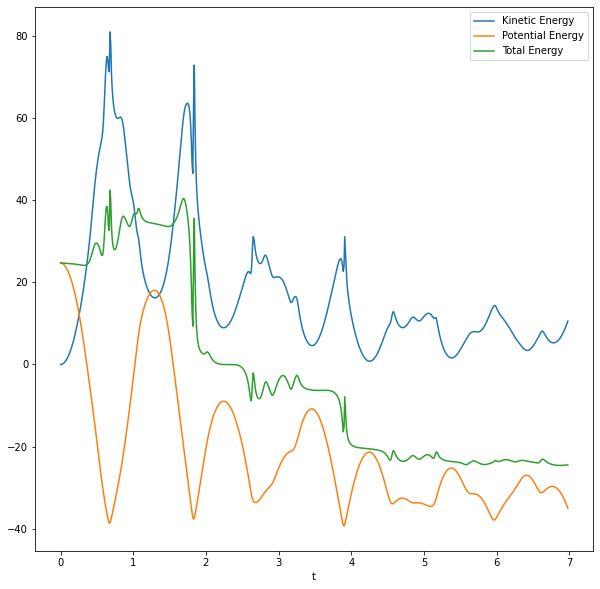

In [36]:
# Plot Kinetic Energy, Potential Energy and Total Energy: No need to change 
kinetic_energy_hist_np = np.array(kinetic_energy_hist)
potential_energy_hist_np = np.array(potential_energy_hist)
total_energy_hist_np = np.array(total_energy_hist).reshape(-1)
ts = np.arange(0, tf-dt, dt)
fig= plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)   
ax.plot(ts, kinetic_energy_hist_np, label='Kinetic Energy')
ax.plot(ts, potential_energy_hist_np, label='Potential Energy')
ax.plot(ts, total_energy_hist_np, label='Total Energy')
ax.legend()
ax.set_xlabel('t')
plt.show()

# (Optional) [10 pts] Explain why the total energy of the arm changes over time. 
Hint: You can try different time step other than 0.001 to show how the simulation accuracy changes total energy profile.

if the 